# Import Library

In [66]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20,8)

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Read Dataset

In [67]:
df1 = pd.read_csv('Case Study - Customer.csv', delimiter=';')
df2 = pd.read_csv('Case Study - Store.csv', delimiter=';')
df3 = pd.read_csv('Case Study - Product.csv', delimiter=';')
df4 = pd.read_csv('Case Study - Transaction.csv', delimiter=';')

In [68]:
print('Kolom Customer', list(df1.columns))
print('Kolom Store', list(df2.columns))
print('Kolom Product', list(df3.columns))
print('Kolom Transaction', list(df4.columns))

Kolom Customer ['CustomerID', 'Age', 'Gender', 'Marital Status', 'Income']
Kolom Store ['StoreID', 'StoreName', 'GroupStore', 'Type', 'Latitude', 'Longitude']
Kolom Product ['ProductID', 'Product Name', 'Price']
Kolom Transaction ['TransactionID', 'CustomerID', 'Date', 'ProductID', 'Price', 'Qty', 'TotalAmount', 'StoreID']


In [69]:
print('Row Customer:',df1.shape[0])
print('Row Store:',df2.shape[0])
print('Row Product:',df3.shape[0])
print('Row Transaction:',df4.shape[0])

Row Customer: 447
Row Store: 14
Row Product: 10
Row Transaction: 5020


In [70]:
df = pd.merge(df1, df4, on='CustomerID', how='outer')
df = pd.merge(df, df2, on='StoreID', how='outer')
df = pd.merge(df, df3, on='ProductID', how='outer')

df.shape

(5020, 19)

In [71]:
df.columns

Index(['CustomerID', 'Age', 'Gender', 'Marital Status', 'Income',
       'TransactionID', 'Date', 'ProductID', 'Price_x', 'Qty', 'TotalAmount',
       'StoreID', 'StoreName', 'GroupStore', 'Type', 'Latitude', 'Longitude',
       'Product Name', 'Price_y'],
      dtype='object')

In [72]:
df.drop(columns='Price_y', inplace=True)
df.rename(columns={'Price_x':'Price'}, inplace=True)

# EDA

In [73]:
df.head()

,CustomerID,Age,Gender,Marital Status,Income,TransactionID,Date,ProductID,Price,Qty,TotalAmount,StoreID,StoreName,GroupStore,Type,Latitude,Longitude,Product Name
0,1,55,1,Married,"5,12",TR54475,23/02/2022,P8,16000,1,16000,9,Lingga,Lingga,Modern Trade,"-3,654703","128,190643",Oat
1,5,58,1,Married,"3,57",TR53643,22/05/2022,P8,16000,3,48000,9,Lingga,Lingga,Modern Trade,"-3,654703","128,190643",Oat
2,7,31,0,Married,"4,57",TR5151,10/03/2022,P8,16000,2,32000,9,Lingga,Lingga,Modern Trade,"-3,654703","128,190643",Oat
3,19,24,1,Single,"4,14",TR98635,18/06/2022,P8,16000,1,16000,9,Lingga,Lingga,Modern Trade,"-3,654703","128,190643",Oat
4,28,55,0,Married,"6,08",TR9420,12/01/2022,P8,16000,3,48000,9,Lingga,Lingga,Modern Trade,"-3,654703","128,190643",Oat


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      5020 non-null   int64 
 1   Age             5020 non-null   int64 
 2   Gender          5020 non-null   int64 
 3   Marital Status  4976 non-null   object
 4   Income          5020 non-null   object
 5   TransactionID   5020 non-null   object
 6   Date            5020 non-null   object
 7   ProductID       5020 non-null   object
 8   Price           5020 non-null   int64 
 9   Qty             5020 non-null   int64 
 10  TotalAmount     5020 non-null   int64 
 11  StoreID         5020 non-null   int64 
 12  StoreName       5020 non-null   object
 13  GroupStore      5020 non-null   object
 14  Type            5020 non-null   object
 15  Latitude        5020 non-null   object
 16  Longitude       5020 non-null   object
 17  Product Name    5020 non-null   object
dtypes: int64

In [75]:
# Mengelempokkan kolom berdasarkan tipe data
cat = ['Gender', 'Marital Status', 'StoreName', 'GroupStore', 'Type', 'Product Name']
num = ['Age', 'Price', 'Qty', 'TotalAmount', 'Income']
ID = ['CustomerID', 'ProductID', 'TransactionID', 'StoreID']
geoloc = ['Latitude', 'Longitude']
date = ['Date']

In [76]:
# Mengubah tipe data
df['Gender'] = df['Gender'].astype('object')

df['Income'] = df['Income'].str.replace(',', '.')
df['Income'] = df['Income'].astype('float')

for i in ID:
    df[i] = df[i].astype('object')

for j in geoloc:
    df[j] = df[j].str.replace(',', '.')
    df[j] = df[j].astype('float')

import datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [77]:
df[cat].describe()

,Gender,Marital Status,StoreName,GroupStore,Type,Product Name
count,5020,4976,5020,5020,5020,5020
unique,2,2,12,7,2,10
top,0,Married,Lingga,Prima,General Trade,Thai Tea
freq,2746,3779,738,1085,2851,814


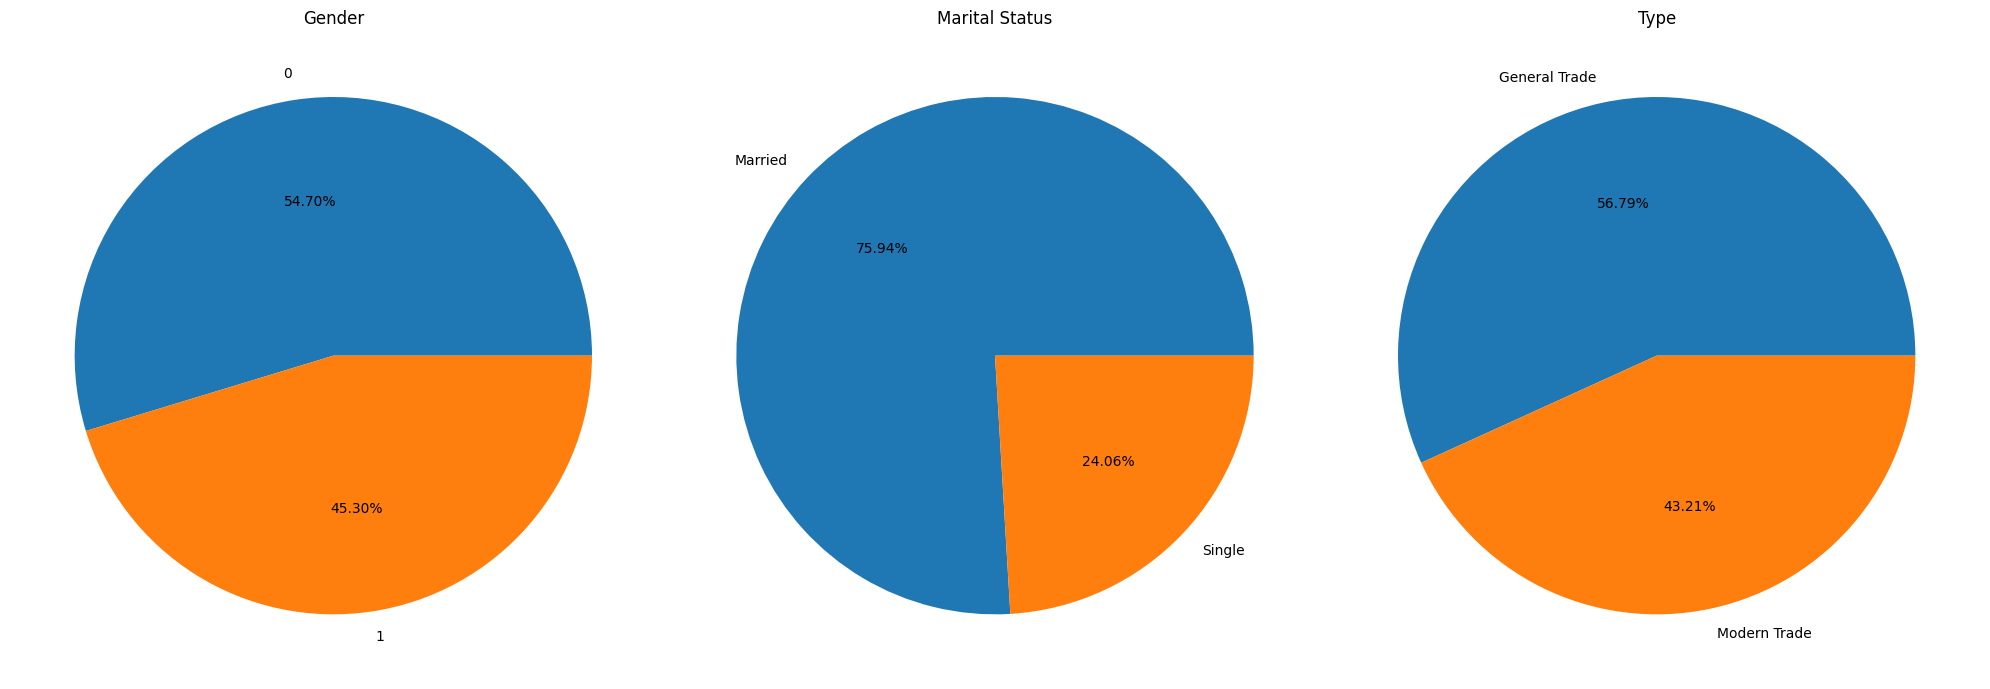

In [78]:
# Menghitung persentase untuk setiap kategori
gender = df['Gender'].value_counts(normalize=True)
marital = df['Marital Status'].value_counts(normalize=True)
type = df['Type'].value_counts(normalize=True)

# Membuat pie chart untuk persentase
percentages = [gender, marital, type]
labels = ['Gender', 'Marital Status', 'Type']

for i in range(len(percentages)):
    plt.subplot(1, 3, i+1)
    plt.pie(percentages[i], labels=percentages[i].index, autopct='%1.2f%%')
    plt.title(labels[i])

plt.tight_layout()
plt.show()

In [79]:
df[num].describe()

,Age,Price,Qty,TotalAmount,Income
count,5020.000000,5020.000000,5020.000000,5020.000000,5020.000000
mean,40.003586,9684.800797,3.644622,32279.482072,8.623713
std,12.834719,4600.708780,1.855295,19675.462455,6.518242
min,0.000000,3200.000000,1.000000,7500.000000,0.000000
25%,30.000000,4200.000000,2.000000,16000.000000,4.220000
50%,39.000000,9400.000000,3.000000,28200.000000,7.720000
75%,51.000000,15000.000000,5.000000,47000.000000,10.780000
max,72.000000,18000.000000,10.000000,88000.000000,71.300000


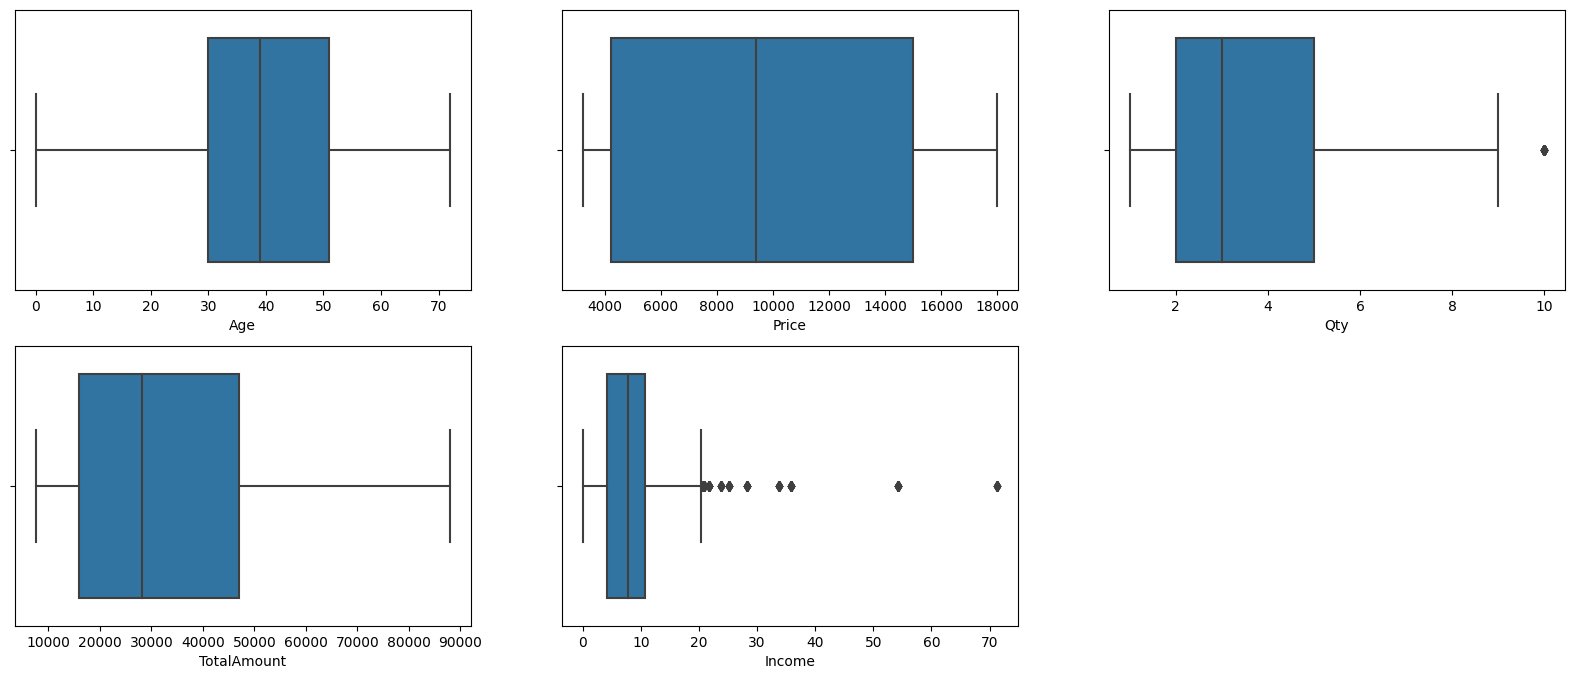

In [80]:
# Melihat persebaran data numerik
for i in range(len(num)):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=df, x=num[i])

plt.show()

In [81]:
df[geoloc].describe()

,Latitude,Longitude
count,5020.000000,5020.000000
mean,-2.942236,109.600789
std,4.323225,8.357593
min,-7.797068,95.323753
25%,-6.914864,104.756554
50%,-5.135399,110.370529
75%,0.533505,114.590111
max,5.548290,128.190643


In [82]:
df[ID].describe()

,CustomerID,ProductID,TransactionID,StoreID
count,5020,5020,5020,5020
unique,447,10,4908,14
top,156,P5,TR71313,9
freq,21,814,3,370


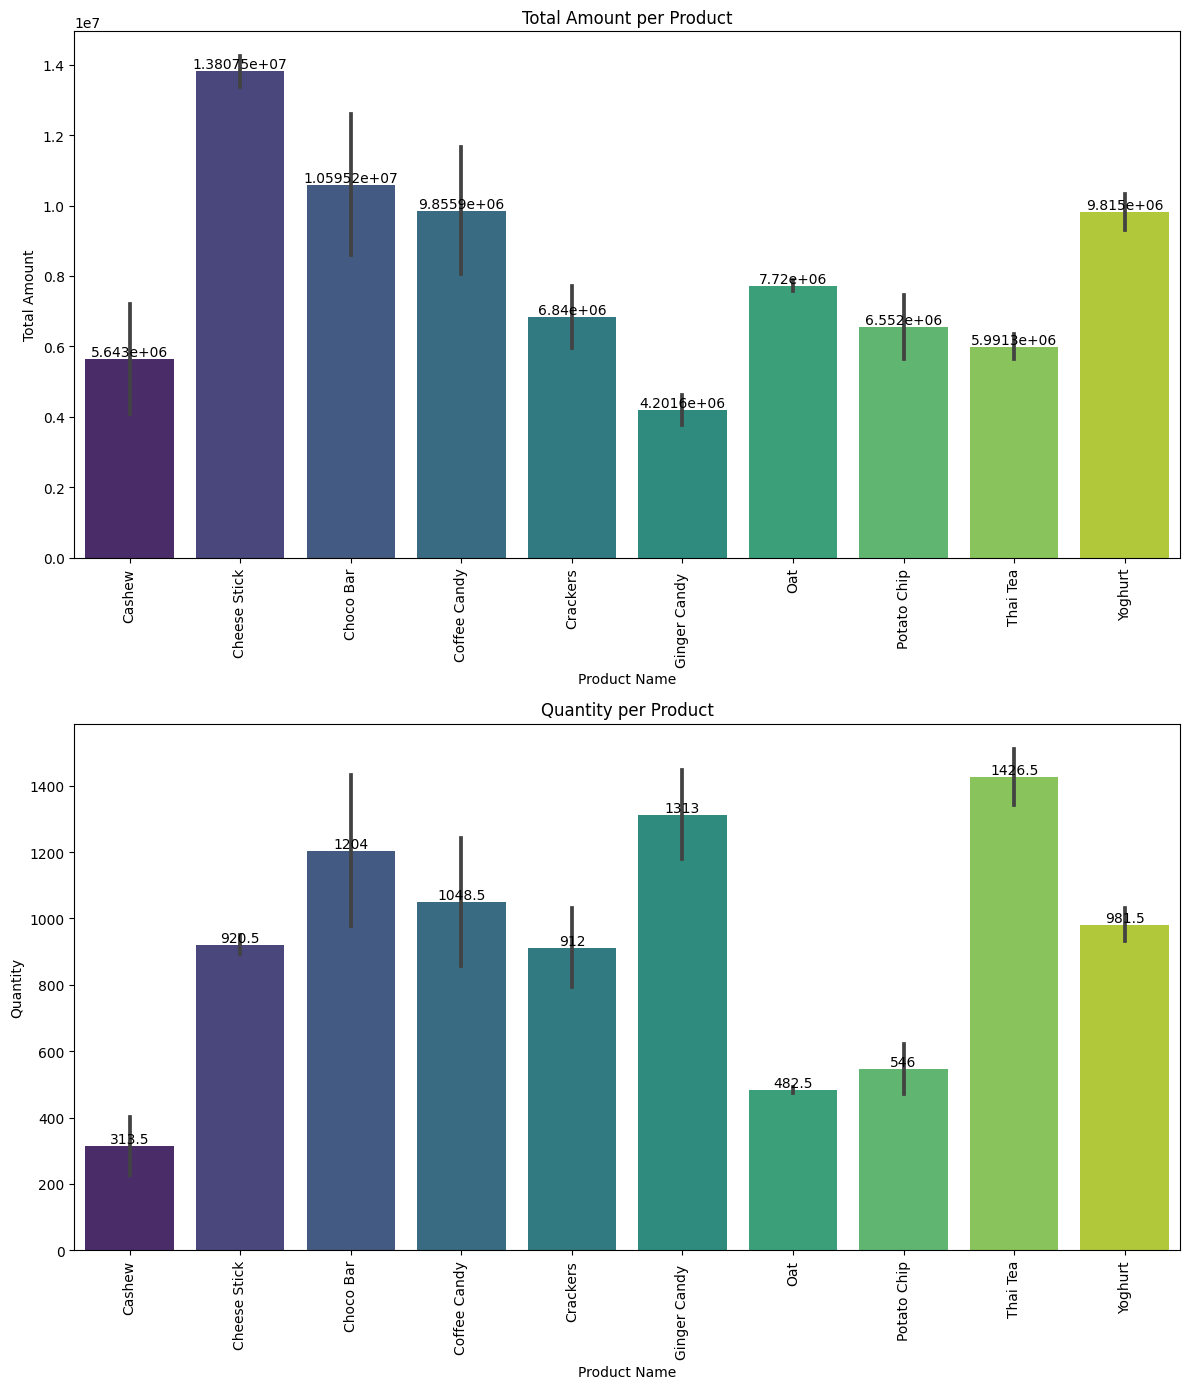

In [83]:
product = df.groupby(['Product Name', 'Gender']).agg({'Qty':'sum', 'TotalAmount':'sum'}).reset_index()

plt.figure(figsize=(12, 14))
# Membuat barplot
plt.subplot(2, 1, 1)
ax = sns.barplot(data=product, x='Product Name', y='TotalAmount', palette='viridis')

# Menambah isi pada plot
plt.ylabel('Total Amount')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Total Amount per Product')
plt.xticks(rotation=90)

# Membuat barplot
plt.subplot(2, 1, 2)
ax = sns.barplot(data=product, x='Product Name', y='Qty', palette='viridis')

# Menambah isi pada plot
plt.ylabel('Quantity')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Quantity per Product')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

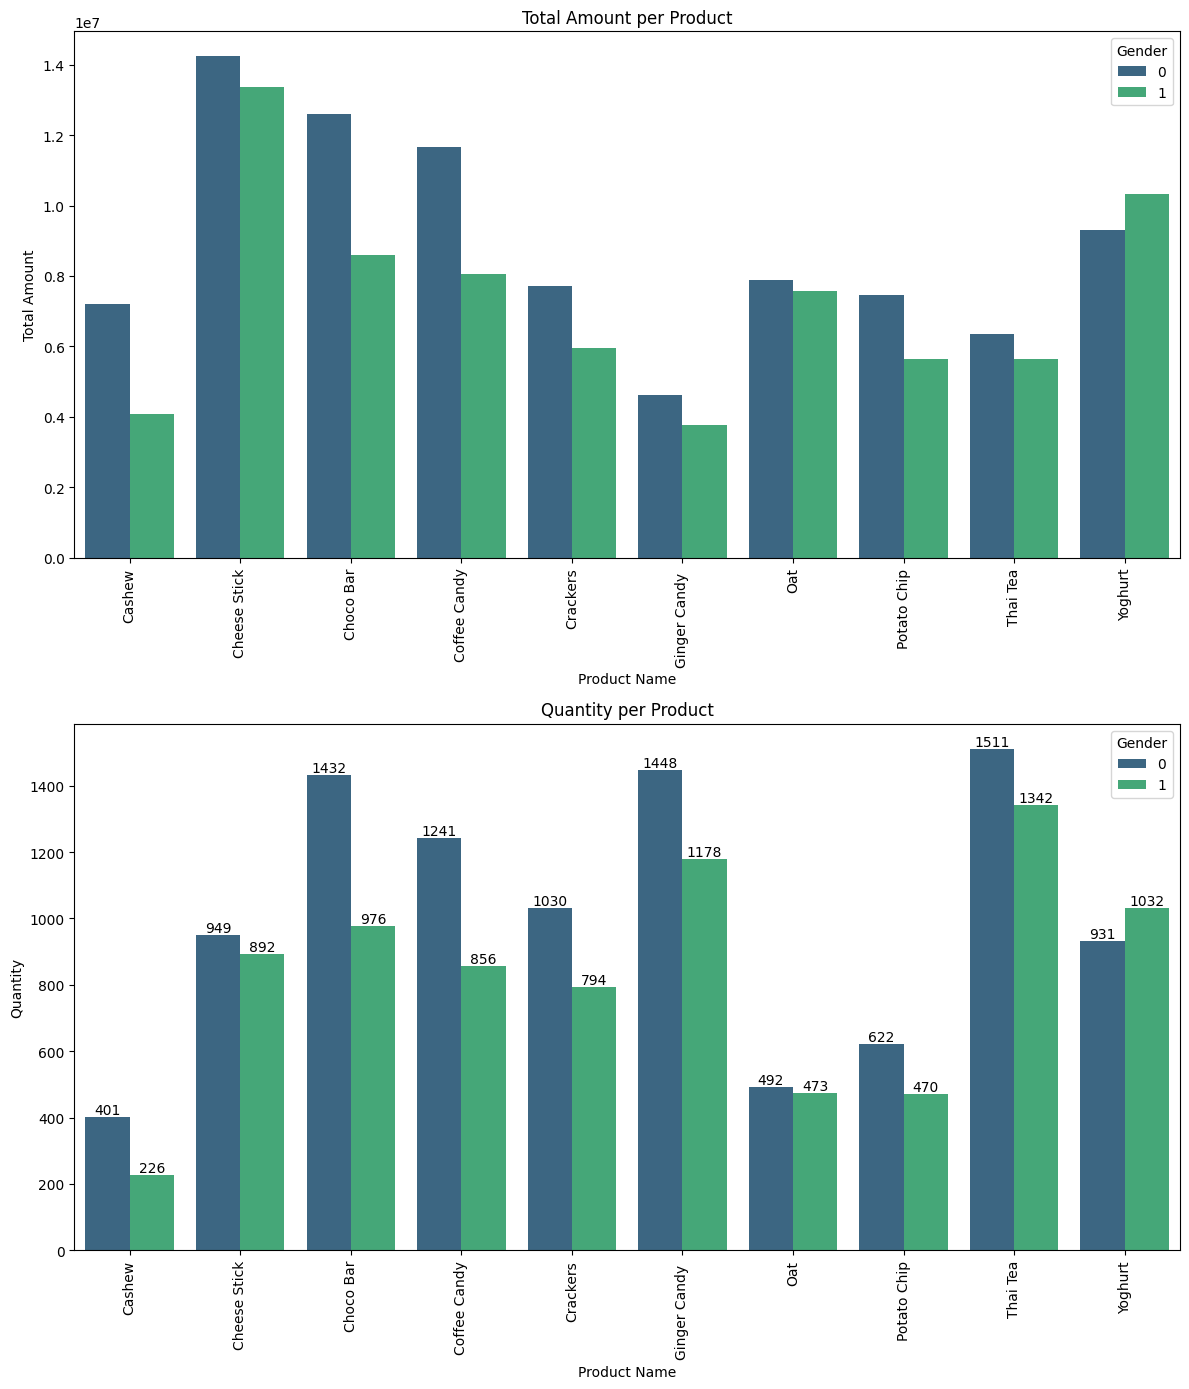

In [84]:
plt.figure(figsize=(12, 14))
# Membuat barplot
plt.subplot(2, 1, 1)
ax = sns.barplot(data=product, x='Product Name', y='TotalAmount', hue='Gender', palette='viridis')

# Menambah isi pada plot
plt.ylabel('Total Amount')
plt.title('Total Amount per Product')
plt.xticks(rotation=90)

# Membuat barplot
plt.subplot(2, 1, 2)
ax = sns.barplot(data=product, x='Product Name', y='Qty', hue='Gender', palette='viridis')

# Menambah isi pada plot
plt.ylabel('Quantity')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Quantity per Product')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

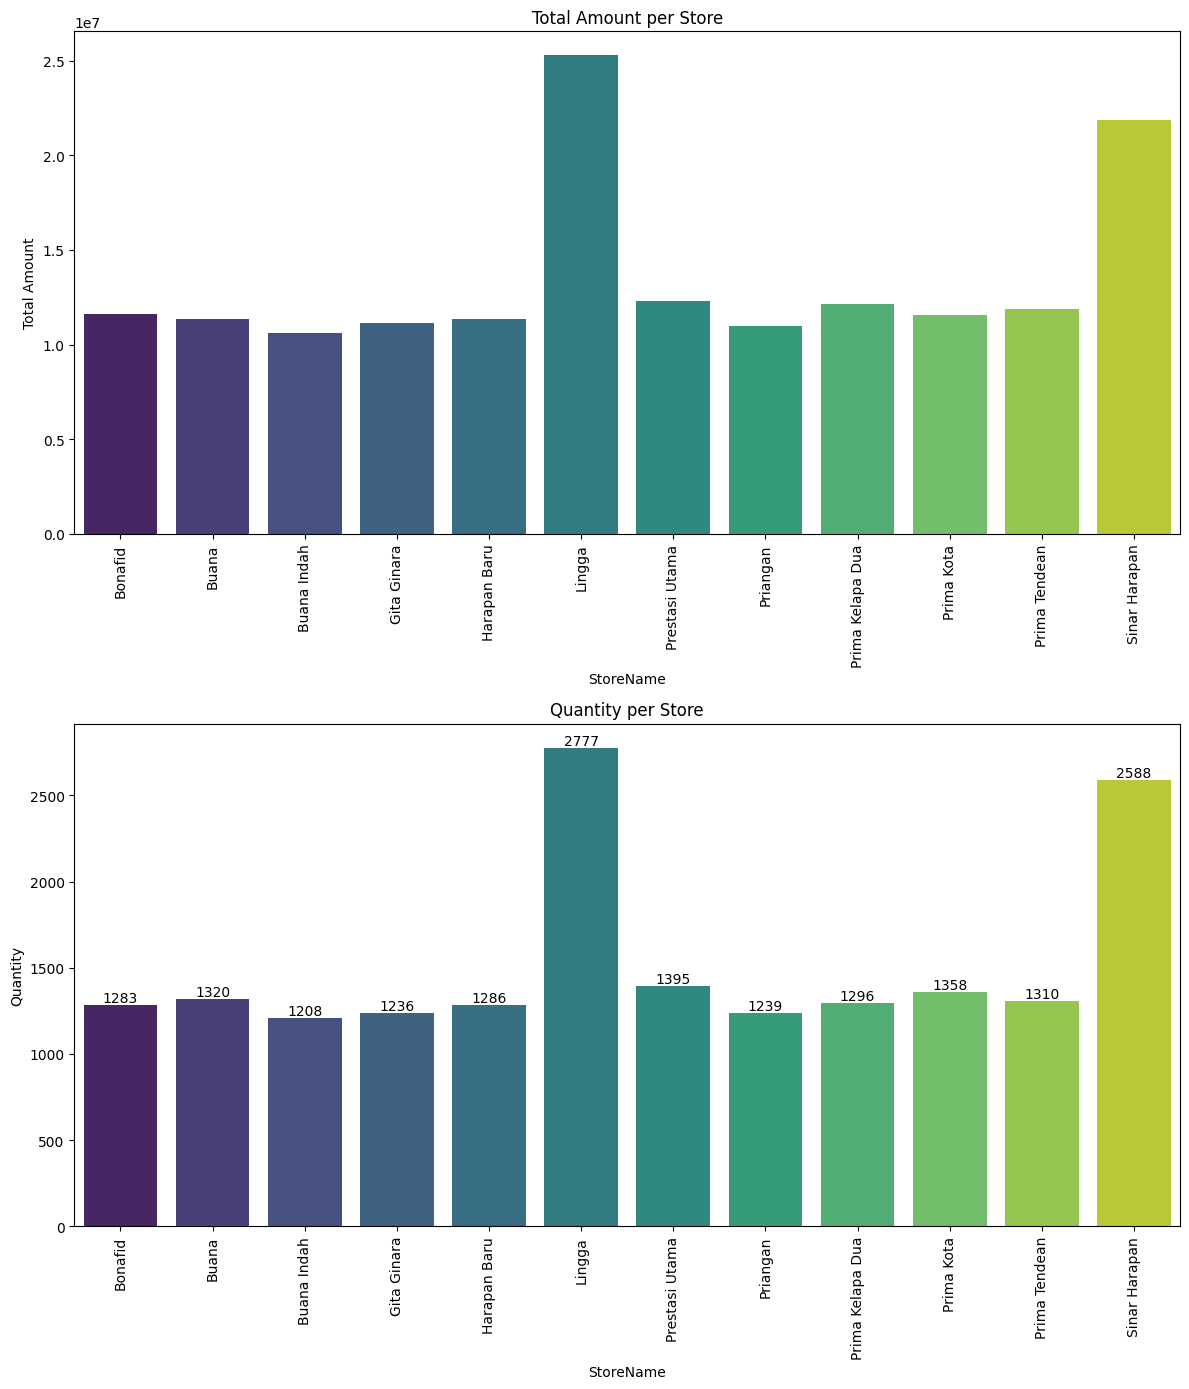

In [85]:
store = df.groupby('StoreName').agg({'Qty':'sum', 'TotalAmount':'sum'}).reset_index()

plt.figure(figsize=(12, 14))
# Membuat barplot
plt.subplot(2, 1, 1)
ax = sns.barplot(data=store, x='StoreName', y='TotalAmount', palette='viridis')

# Menambah isi pada plot
plt.ylabel('Total Amount')
plt.title('Total Amount per Store')
plt.xticks(rotation=90)

# Membuat barplot
plt.subplot(2, 1, 2)
ax = sns.barplot(data=store, x='StoreName', y='Qty', palette='viridis')

# Menambah isi pada plot
plt.ylabel('Quantity')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Quantity per Store')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

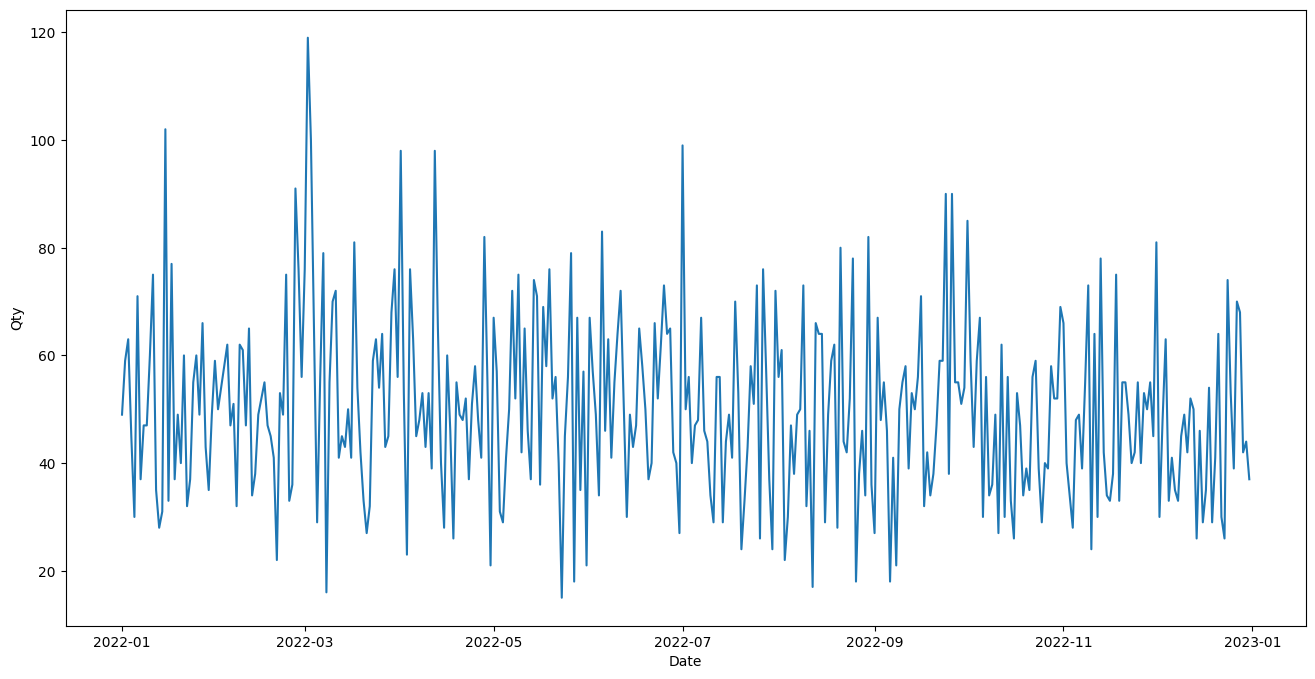

In [87]:
reg = df.groupby(['Date']).agg({'Qty':'sum'})

plt.figure(figsize=(16,8))
sns.lineplot(data=reg, x=reg.index, y='Qty')

plt.show()

# Data Preprocessing

In [88]:
data = df.copy()

## Missing Value

In [89]:
data.isna().sum()

CustomerID         0
Age                0
Gender             0
Marital Status    44
Income             0
TransactionID      0
Date               0
ProductID          0
Price              0
Qty                0
TotalAmount        0
StoreID            0
StoreName          0
GroupStore         0
Type               0
Latitude           0
Longitude          0
Product Name       0
dtype: int64

In [90]:
data['Marital Status'] = data['Marital Status'].fillna(data['Marital Status'].mode()[0])

## Feature Encoding

In [91]:
data['Gender'] = data['Gender'].astype('int')

data['Marital Status'] = data['Marital Status'].replace({'Single':0, 'Married':1})
data.rename(columns={'Marital Status':'Married'}, inplace=True)

data['Type'] = data['Type'].replace({'Modern Trade':0, 'General Trade':1})

data['ProductID'] = data['ProductID'].astype('category').cat.codes

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CustomerID     5020 non-null   object        
 1   Age            5020 non-null   int64         
 2   Gender         5020 non-null   int32         
 3   Married        5020 non-null   int64         
 4   Income         5020 non-null   float64       
 5   TransactionID  5020 non-null   object        
 6   Date           5020 non-null   datetime64[ns]
 7   ProductID      5020 non-null   int8          
 8   Price          5020 non-null   int64         
 9   Qty            5020 non-null   int64         
 10  TotalAmount    5020 non-null   int64         
 11  StoreID        5020 non-null   object        
 12  StoreName      5020 non-null   object        
 13  GroupStore     5020 non-null   object        
 14  Type           5020 non-null   int64         
 15  Latitude       5020 n

# Modeling

# Time Series

## Split Data

In [92]:
size = int(reg.shape[0]*0.8)

In [93]:
reg_train = reg.iloc[:size]
reg_test = reg.iloc[size:]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


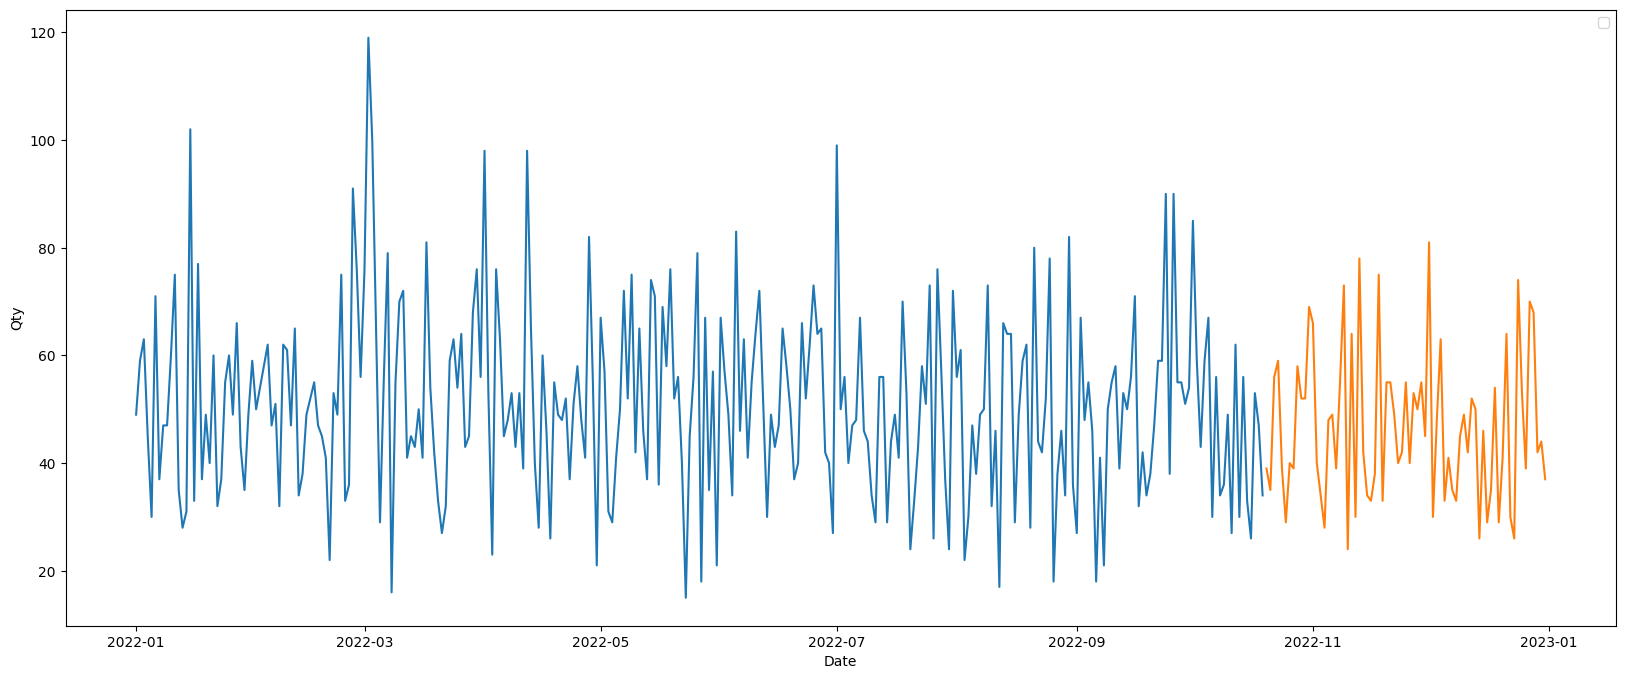

In [94]:
sns.lineplot(reg_train, x=reg_train.index, y='Qty')
sns.lineplot(reg_test, x=reg_test.index, y='Qty')
plt.legend()
plt.show()

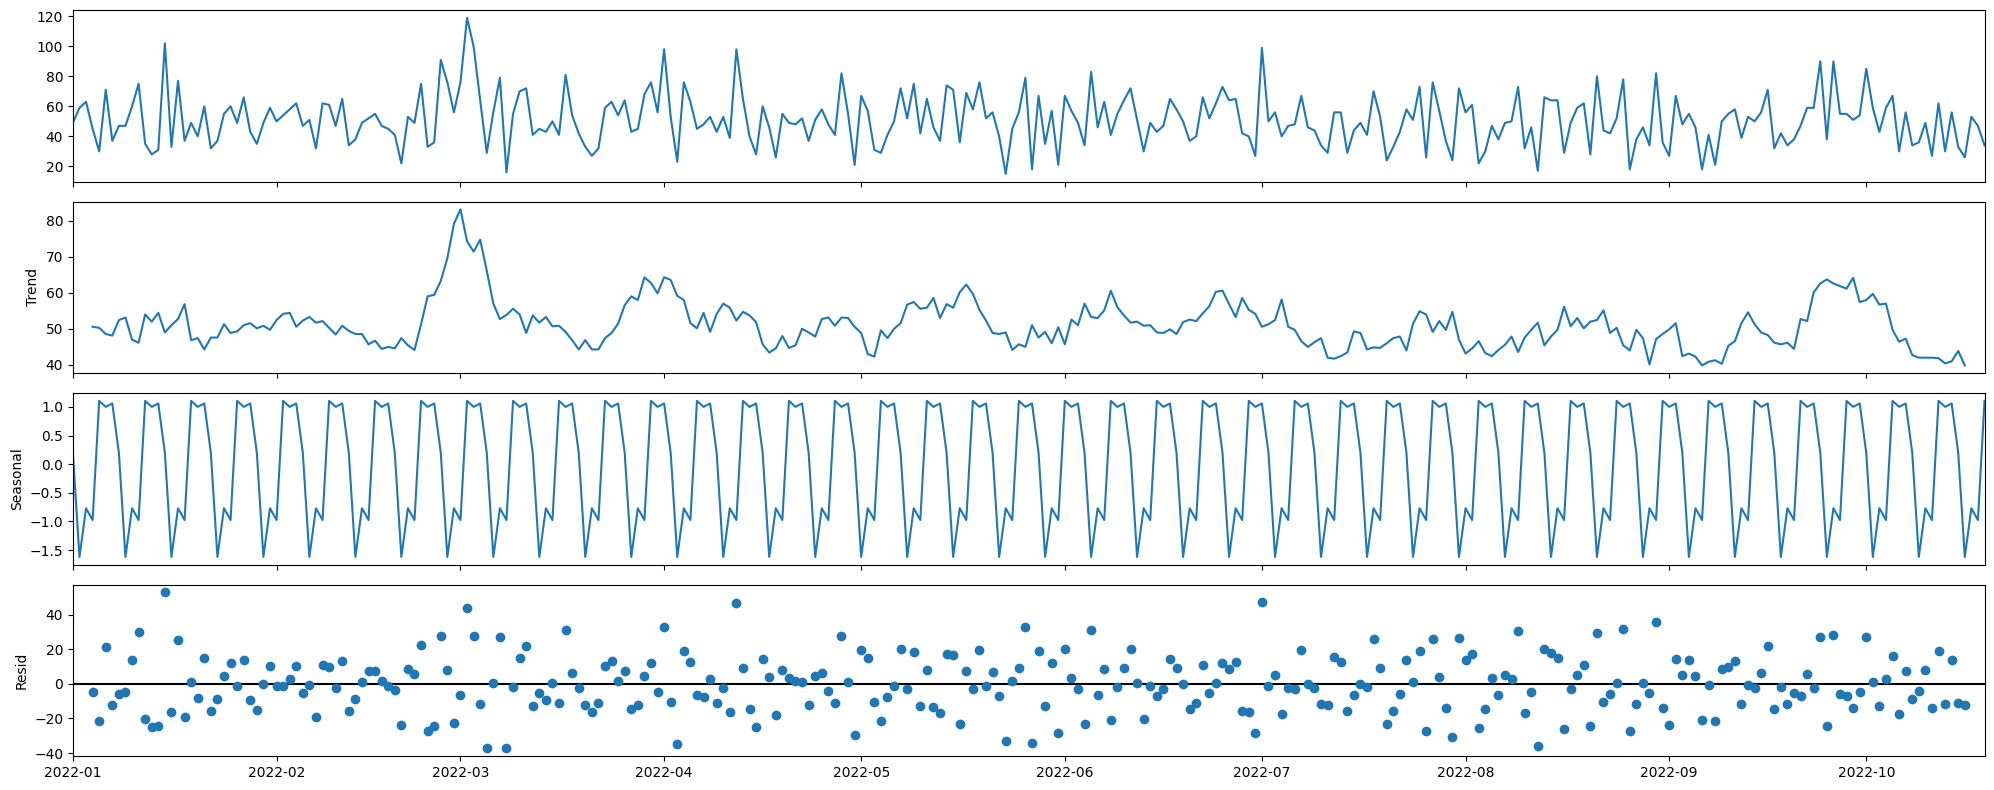

In [95]:
decomposition = sm.tsa.seasonal_decompose(reg_train, model='additive')
fig = decomposition.plot()
plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

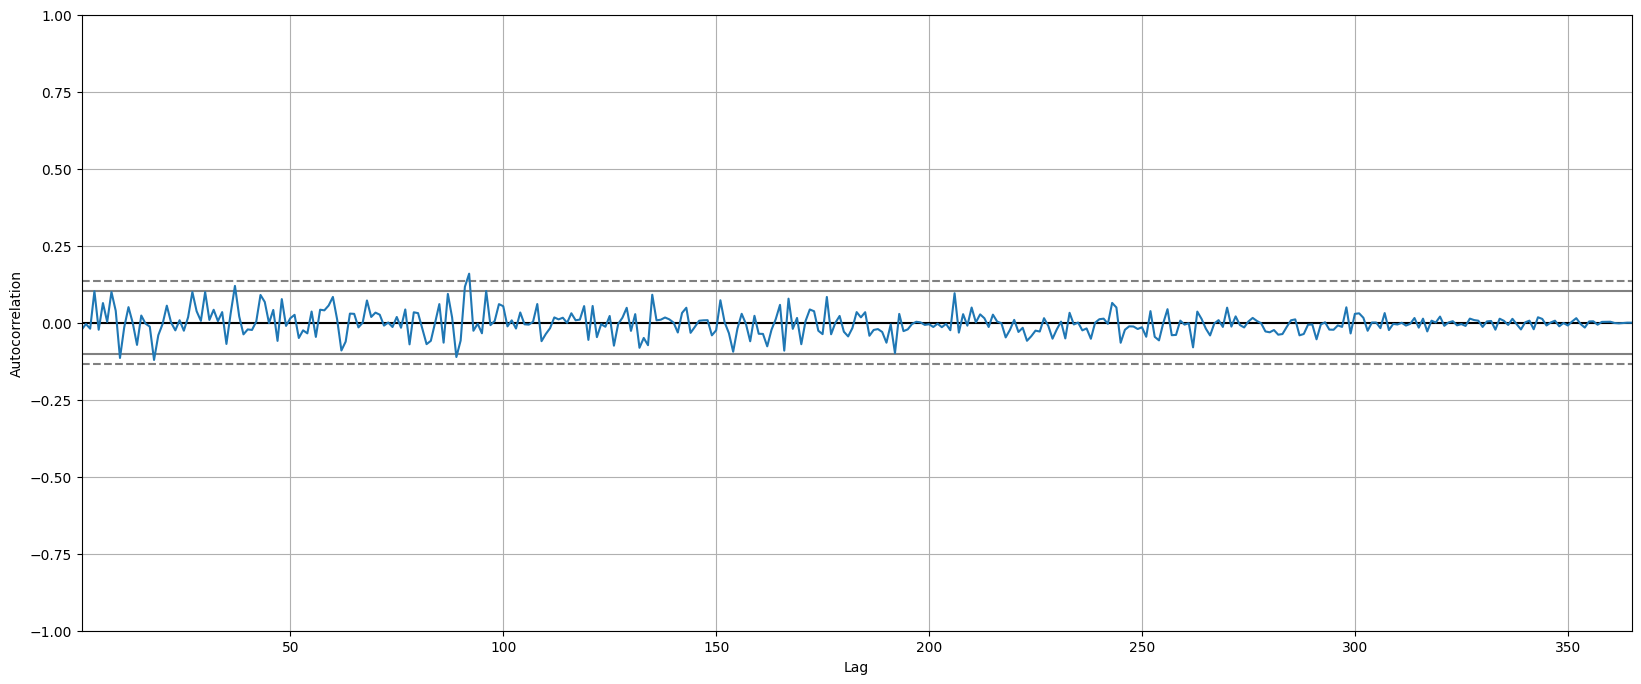

In [96]:
pd.plotting.autocorrelation_plot(reg)

In [97]:
# Fungsi untuk evaluasi
def eval(y_actual, y_pred):
    print(f'RMSE value: {mean_squared_error(y_actual, y_pred, squared=False)}')
    print(f'MAE value: {mean_absolute_error(y_actual, y_pred)}')

RMSE value: 14.450889128463212
MAE value: 11.85226216457913


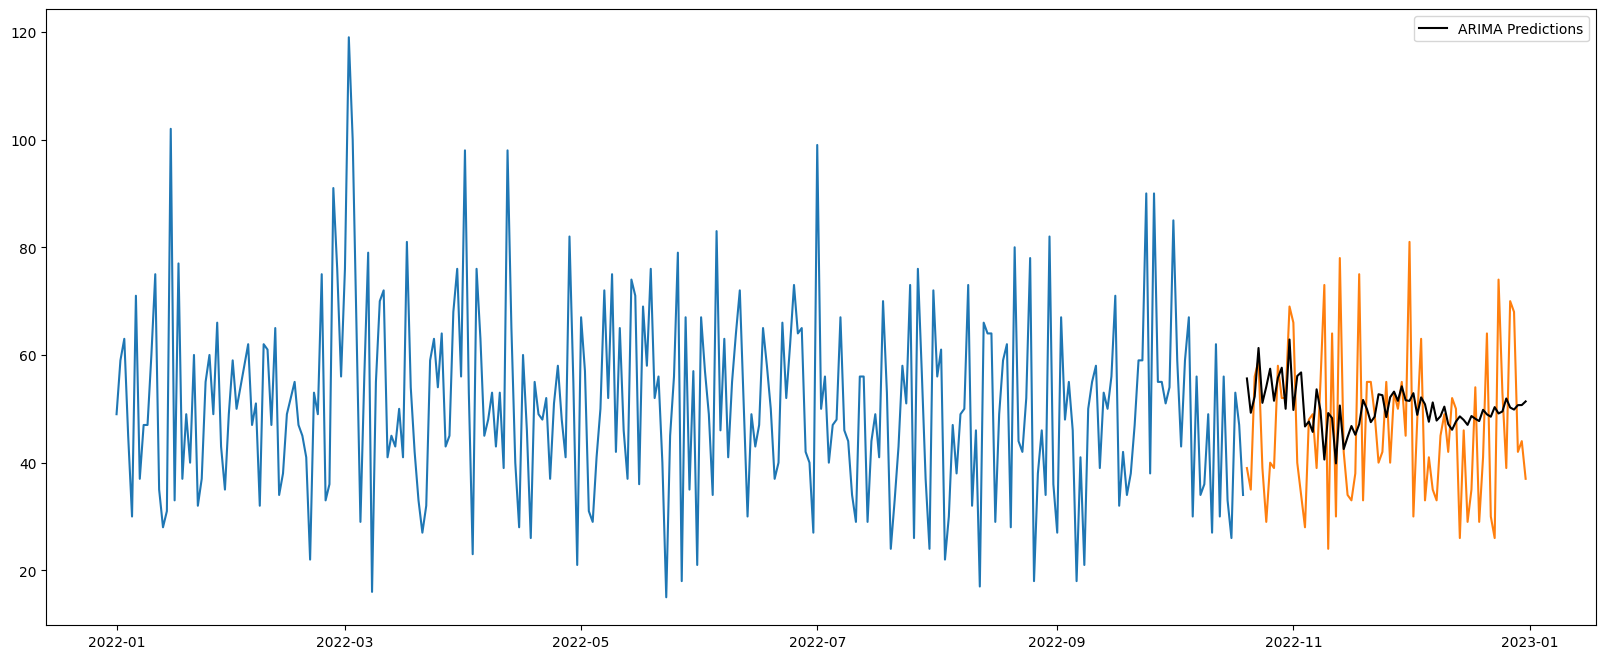

In [98]:
# ARIMA
y = reg_train['Qty']

model = sm.tsa.ARIMA(y, order=(37,2,2))
result = model.fit()

y_pred = result.get_forecast(len(reg_test))

y_pred = y_pred.conf_int()
y_pred['predictions'] = result.predict(start=y_pred.index[0], end=y_pred.index[-1])
y_pred.index = reg_test.index
y_pred_out = y_pred['predictions']
eval(reg_test, y_pred_out)

plt.plot(reg_train)
plt.plot(reg_test)
plt.plot(y_pred_out, color='black', label='ARIMA Predictions')
plt.legend()

plt.show()

# Clustering

In [99]:
data.head()

,CustomerID,Age,Gender,Married,Income,TransactionID,Date,ProductID,Price,Qty,TotalAmount,StoreID,StoreName,GroupStore,Type,Latitude,Longitude,Product Name
0,1,55,1,1,5.12,TR54475,2022-02-23,8,16000,1,16000,9,Lingga,Lingga,0,-3.654703,128.190643,Oat
1,5,58,1,1,3.57,TR53643,2022-05-22,8,16000,3,48000,9,Lingga,Lingga,0,-3.654703,128.190643,Oat
2,7,31,0,1,4.57,TR5151,2022-03-10,8,16000,2,32000,9,Lingga,Lingga,0,-3.654703,128.190643,Oat
3,19,24,1,0,4.14,TR98635,2022-06-18,8,16000,1,16000,9,Lingga,Lingga,0,-3.654703,128.190643,Oat
4,28,55,0,1,6.08,TR9420,2022-01-12,8,16000,3,48000,9,Lingga,Lingga,0,-3.654703,128.190643,Oat


In [100]:
cluster = data.groupby('CustomerID').agg(
    {'TransactionID':'count',
     'Qty':'sum',
     'TotalAmount':'sum'}
).reset_index()

cluster = cluster.rename(columns={'TransactionID':'Transaction'})

cluster.head()

,CustomerID,Transaction,Qty,TotalAmount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600


In [101]:
scaler = StandardScaler()

normal = cluster.drop(columns='CustomerID')
normal = scaler.fit_transform(normal)
normal

array([[ 1.77981554,  1.49652728,  2.09476796],
       [ 0.54588371,  1.26109285,  0.23926861],
       [ 1.16284962,  1.18261471,  0.67221846],
       ...,
       [ 2.08829849,  2.12435243,  1.80479599],
       [-0.0710822 ,  0.0839207 ,  0.48827502],
       [ 0.54588371,  0.0839207 ,  0.61679446]])

## Choose n Cluster

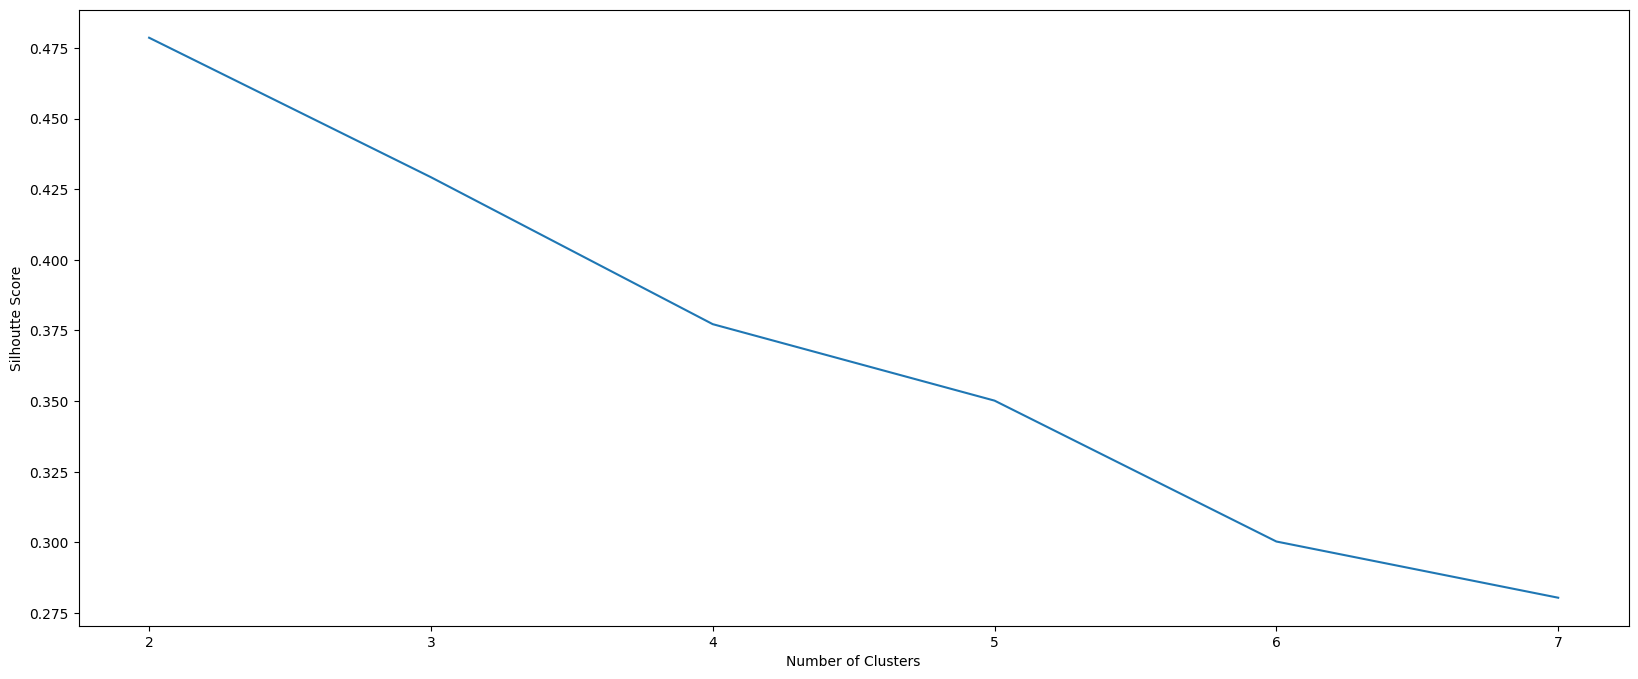

In [102]:
# silhouette score
fits = []
score = []

for k in range(2,8):
    model = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(normal)
    fits.append(model)
    score.append(silhouette_score(normal, model.labels_, metric='euclidean' ))

sns.lineplot(x=range(2,8), y=score)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhoutte Score')
plt.show()

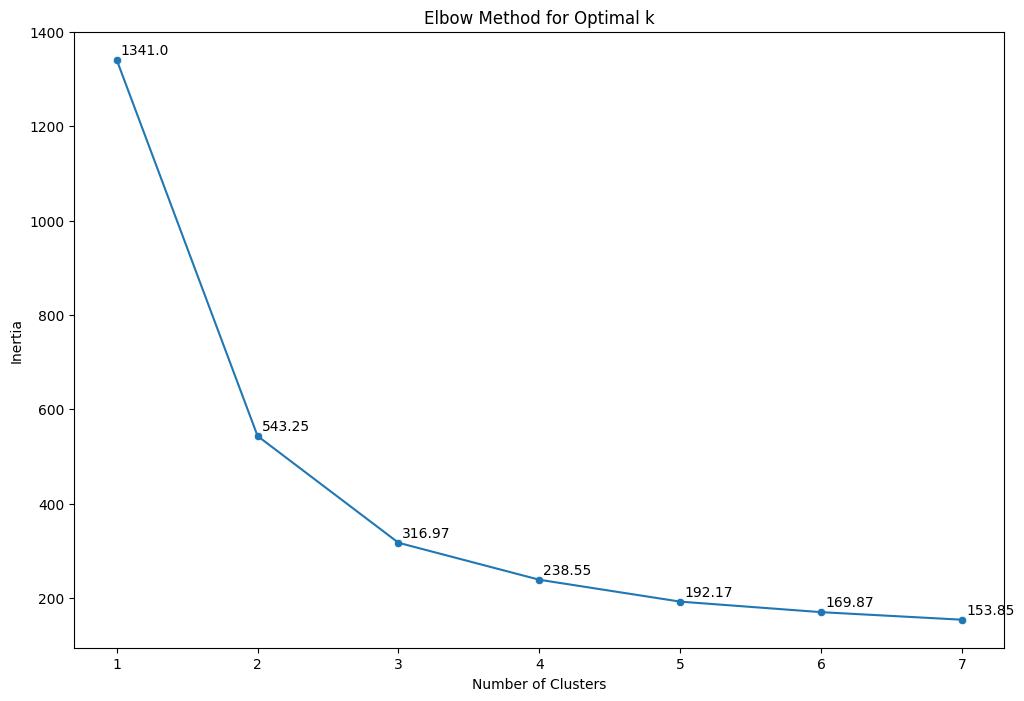

In [103]:
# elbow score
inertia = []

for i in range(1, 8):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(normal)
    inertia.append(np.round(kmeans.inertia_, 2))

x = range(1, 8)

plt.figure(figsize=(12, 8))
sns.lineplot(x=x, y=inertia)
sns.scatterplot(x=x, y=inertia)

for i, label in enumerate(inertia):
    plt.text(x[i] + 0.2, inertia[i] + 5, label, ha='center', va='bottom')

plt.xticks(range(1, 8))
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [104]:
cluster['label'] = fits[0].labels_
cluster.head()

,CustomerID,Transaction,Qty,TotalAmount,label
0,1,17,60,623300,0
1,2,13,57,392300,0
2,3,15,56,446200,0
3,4,10,46,302500,1
4,5,7,27,268600,1


In [105]:
cluster.groupby('label').agg({
    'CustomerID':'count',
    'Transaction':'mean',
    'Qty':'mean',
    'TotalAmount':'mean'
})

,CustomerID,Transaction,Qty,TotalAmount
label,,,,
0,189,14.126984,52.555556,474043.386243
1,258,9.108527,32.414729,280809.302326


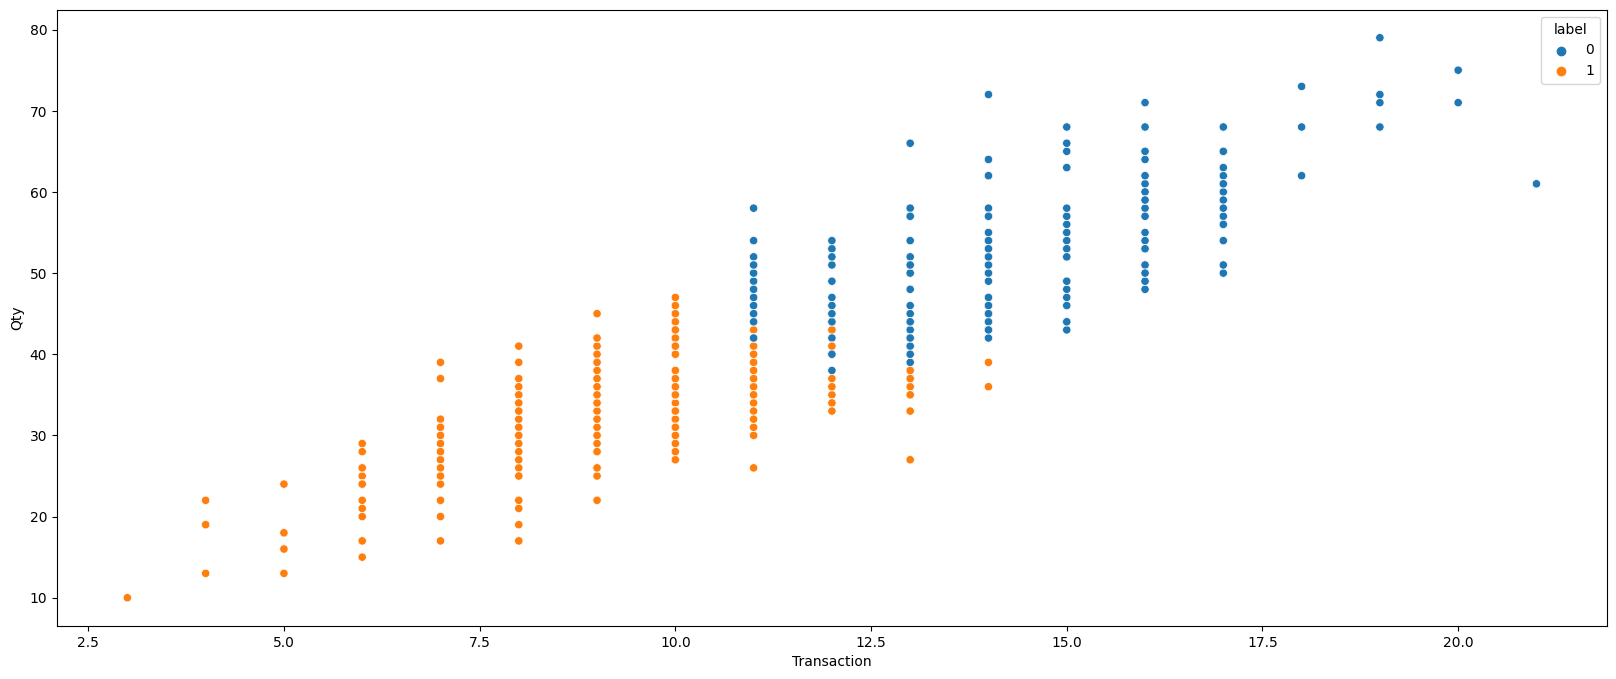

In [111]:
sns.scatterplot(data=cluster, x='Transaction', y='Qty', hue='label')
plt.show()

In [107]:
labels = cluster[['CustomerID', 'label']]

df = pd.merge(df, labels, on='CustomerID')
df.head()

,CustomerID,Age,Gender,Marital Status,Income,TransactionID,Date,ProductID,Price,Qty,TotalAmount,StoreID,StoreName,GroupStore,Type,Latitude,Longitude,Product Name,label
0,1,55,1,Married,5.12,TR54475,2022-02-23,P8,16000,1,16000,9,Lingga,Lingga,Modern Trade,-3.654703,128.190643,Oat,0
1,1,55,1,Married,5.12,TR72489,2022-10-14,P8,16000,2,32000,13,Buana,Buana,General Trade,-1.269160,116.825264,Oat,0
2,1,55,1,Married,5.12,TR35770,2022-11-08,P8,16000,1,16000,5,Bonafid,Gita,General Trade,-7.250445,112.768845,Oat,0
3,1,55,1,Married,5.12,TR60228,2022-07-01,P3,7500,5,37500,9,Lingga,Lingga,Modern Trade,-3.654703,128.190643,Crackers,0
4,1,55,1,Married,5.12,TR44292,2022-05-05,P3,7500,4,30000,1,Prima Tendean,Prima,Modern Trade,-6.200000,106.816666,Crackers,0


In [115]:
# Simpan data
df.to_csv('Kalbe.csv', index=False)